In [12]:
import cv2
import numpy as np
import requests
import io
import torch
import ttach as tta
import torchvision.transforms as transforms
from PIL import ImageTk, Image
from typing import Callable, List, Tuple
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from torchvision.transforms import Compose, Normalize, ToTensor
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from typing import List, Callable, Optional
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [13]:
import activations 
import functions as func
import base
from cam import CAM
#import utils.HuggingfaceToTensorModelWrapper
from model_tragets import ClassifierOutputTarget
from EigenCAM import EigenCAM
from HuggingfaceToTensorModelWrapper import HuggingfaceToTensorModelWrapper
from ScoreCAM import ScoreCAM
from AblationCAM import AblationCAM

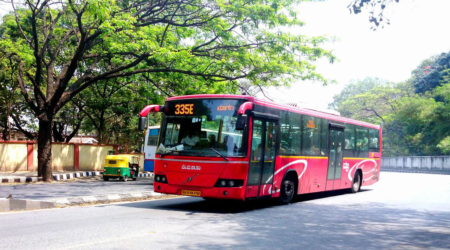

In [14]:
r = requests.get('https://www.indiaspend.com/h-upload/old_images/343409-bmtc-1.jpg',stream=True)
#https://www.perc.org/wp-content/uploads/2020/05/wild-horses-central-nevada-1024x704.jpg
image = Image.open(io.BytesIO(r.content))
size = image.size
# define transformt o resize the image with given size
transform = T.Resize(size = (250,450))

# apply the transform on the input image
image = transform(image)
transform = transforms.ToTensor()
tensor = transform(image).unsqueeze(0)
img = np.array(image)
tensor = tensor.reshape([ 3, 250, 450])
Image.fromarray(img)

In [15]:
def run_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_cam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=tensor,
                          input_image: Image=img,
                          method: Callable=CAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_cam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_cam)
        results = []
        for grayscale_cam in batch_results:
            visualization = func.show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
    return np.hstack(results)
    

In [5]:
from transformers import MobileViTForImageClassification
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small")
#target_layer = model.mobilevit.conv_1x1_exp

In [6]:
targets_for_cam = [ClassifierOutputTarget(func.category_name_to_index(model, "indigo bunting, indigo finch, indigo bird, Passerina cyanea")),
                       ClassifierOutputTarget(func.category_name_to_index(model, "coucal"))]

Now with EigenCAM :


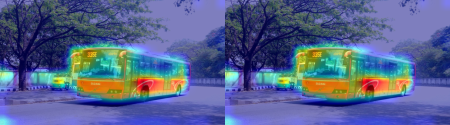

Predicted class 874: trolleybus, trolley coach, trackless trolley
Predicted class 705: passenger car, coach, carriage
Predicted class 654: minibus
Predicted class 779: school bus


In [16]:
print('Now with EigenCAM :')
cam_image = run_cam_on_image(model=model,
                      target_layer=model.mobilevit.encoder.layer[-2],
                      targets_for_cam=targets_for_cam,
                      reshape_transform=None,
                      method=EigenCAM)
display(Image.fromarray(cam_image))
func.print_top_categories(model, tensor)

Now with ScoreCAM :


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:15<00:00,  9.46s/it]


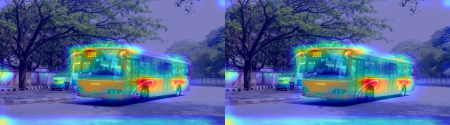

Predicted class 874: trolleybus, trolley coach, trackless trolley
Predicted class 705: passenger car, coach, carriage
Predicted class 654: minibus
Predicted class 779: school bus


In [17]:
print('Now with ScoreCAM :')
display(Image.fromarray(run_cam_on_image(model=model,
                      target_layer=model.mobilevit.encoder.layer[-2],
                      targets_for_cam=targets_for_cam,
                      reshape_transform=None,
                      method=ScoreCAM)))
func.print_top_categories(model, tensor)

Now with AblationCAM :


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.99s/it]


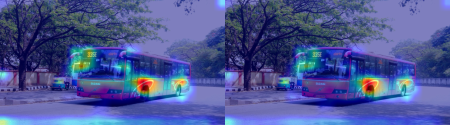

Predicted class 874: trolleybus, trolley coach, trackless trolley
Predicted class 705: passenger car, coach, carriage
Predicted class 654: minibus
Predicted class 779: school bus


In [18]:
print('Now with AblationCAM :')
display(Image.fromarray(run_cam_on_image(model=model,
                      target_layer=model.mobilevit.encoder.layer[-2],
                      targets_for_cam=targets_for_cam,
                      reshape_transform=None,
                      method=AblationCAM)))
func.print_top_categories(model, tensor)